# Notebook to create the figures for Groneberg et al. 2024 'Development of sound production in Danionella cerebrum' 

### Imports and helper functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline
from matplotlib import cm
from matplotlib.patches import Ellipse
import scipy
from scipy import signal

In [ ]:
if 'google.colab' in str(get_ipython()):
  !mkdir datafiles

  !wget https://github.com/danionella/groneberg_et_al_2024/raw/main/datafiles/RM_CompiledClicks.h5 -O ./datafiles/RM_CompiledClicks.h5
  !wget https://github.com/danionella/groneberg_et_al_2024/raw/main/datafiles/RM_Morph.csv -O ./datafiles/RM_Morph.csv
  !wget https://github.com/danionella/groneberg_et_al_2024/raw/main/datafiles/Adult_SL.csv -O ./datafiles/Adult_SL.csv

  !wget https://github.com/danionella/groneberg_et_al_2024/raw/main/datafiles/CR_100CenterClicks.h5 -O ./datafiles/CR_100CenterClicks.h5
  !wget https://github.com/danionella/groneberg_et_al_2024/raw/main/datafiles/CR_Morph.csv -O ./datafiles/CR_Morph.csv
  !wget https://github.com/danionella/groneberg_et_al_2024/raw/main/datafiles/CR_example_traces.npy -O ./datafiles/CR_example_traces.npy
  
  !wget https://github.com/danionella/groneberg_et_al_2024/raw/main/datafiles/24hrec_CompiledClicks.h5 -O ./datafiles/24hrec_CompiledClicks.h5
  !wget https://github.com/danionella/groneberg_et_al_2024/raw/main/datafiles/24hrec_Morph.csv -O ./datafiles/24hrec_Morph.csv
  

In [2]:
# data path: 
path = r'./datafiles'
# settings for plotting  
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('font', size=12)

def removeAxisBox(ax1):
    # Remove the box around the plot
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

# function for detecting bursts from click times
def group_event(events, maxgap):
    # group events which are separated by a delay smaller than maxgap (e.g. for burst detection)
    gaps = np.diff(events)
    shortgaps = gaps<=maxgap
    dsg = np.diff(np.hstack([False, shortgaps.astype('int8'), False]))
    numevents = np.where(dsg<0)[0]-np.where(dsg>0)[0]+1
    groups = pd.DataFrame({'groupstart': events[dsg>0].values, 'groupend': events[dsg<0].values, 'startindex':np.where(dsg>0)[0], 'stopindex':np.where(dsg<0)[0], 'numevents':numevents})
    return groups

## Dataset 1: repeated measure (rm) sound recordings in groups of 10 fish

In [3]:
# load click data
clicks_rm = pd.read_hdf(os.path.join(path, 'RM_CompiledClicks.h5'))
sr_rm = 51200 # samples per second
# load mophology data
morph_rm = pd.read_csv(os.path.join(path, 'RM_Morph.csv'))
adult_morph = pd.read_csv(os.path.join(path, 'Adult_SL.csv'))

### explanation of data structures

In [81]:
print('clicks_rm variable:')
clicks_rm.head()

allClicks variable:


,frame,channel,amplitude,audiofile,age,roundedAge
0,68696836,7,5.459544e+05,20200828_0900_Group1_Audio.flac,4.0,4.0
1,68696837,4,5.980900e+05,20200828_0900_Group1_Audio.flac,4.0,4.0
2,171747421,0,3.826149e+05,20200828_0900_Group1_Audio.flac,4.0,4.0
3,172698097,4,1.530635e+07,20200828_0900_Group1_Audio.flac,4.0,4.0
4,223457342,4,4.173675e+05,20200828_0900_Group1_Audio.flac,4.0,4.0


dataframe object for click data: 
* 'frame' indicates the acquisition frame at which a click was detected, needs to be divided by the sample rate sr_rm to obtain time in seconds 
* 'channel' reports the hydrophone channel the click was detected on
* 'amplitude' of the detected click in arbitrary units
* 'audiofile' refers to the raw datafile (.flac) where these clicks were detected on
* 'age' in weeks post fertilization
* 'roundedAge' in weeks post fertilization, used for measures that are averaged across clicks (inter-click interval and amplitude)

In [4]:
print('morph_rm variable:')
morph_rm.head()

morph_rm variable:


,Age,sex,BL,aSB_Height,aSB_Width
0,4,NaN,5235.340,277.10,262.50
1,4,NaN,4754.573,296.56,272.23
2,4,NaN,4460.515,364.61,330.56
3,4,NaN,5904.600,412.30,388.80
4,4,NaN,6861.214,307.10,251.80


dataframe object for morphology data:
* 'Age' in weeks post fertilization
* 'sex' M: male, F: female where it could be determined
* 'BL' body length measure as standard length (nose to tail base) in μm
* 'aSB_Height' dorso-ventral measure of the diameter of the anterior swim bladder in μm
* 'aSB_Width' rosto-caudal measure of the diameter of the anterior swim bladder in μm

In [83]:
print('adult_morph variable:')
adult_morph.head()

adult_morph variable:


,Tank,sex,BL
0,C1,F,11359.898
1,C1,F,12984.059
2,C1,F,12760.990
3,C1,M,11458.142
4,C1,F,10709.485


dataframe object for morphology data:

* 'Tank' TankID from which the sample was taken
* 'sex' M: male, F: female
* 'BL' body length measure as standard length (nose to tail base) in μm

### Figure 1 B and D - click count and standard length measures

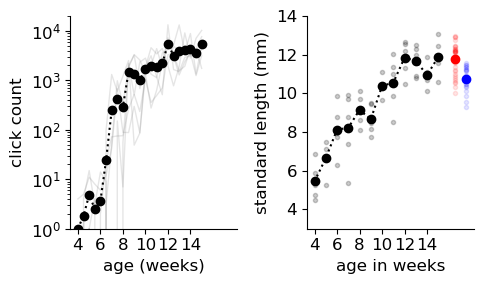

In [5]:
fig,ax = plt.subplots(1,2,figsize=[5,3],sharex=True)
clickall = []
ageL = clicks_rm['age'].unique()

# plot number of clicks
for n in clicks_rm['channel'].unique():
    clickcount = []
    
    for a in clicks_rm['age'].unique():
        frames = clicks_rm['frame'].loc[(clicks_rm['age']==a) & (clicks_rm['channel']==n)]
        clickcount += [len(frames)]
        
    ax[0].plot(ageL,clickcount,alpha=.2,linewidth=1,color='gray')
    clickall += [clickcount]
        
removeAxisBox(ax[0])
removeAxisBox(ax[1])
# plot means
ax[0].plot(ageL,np.mean(clickall,axis=0),'ko')
ax[0].plot(ageL,np.mean(clickall,axis=0),'k:')
# axis settings
ax[0].set_yscale('log')
ax[0].set_xlabel('age (weeks)')
ax[0].set_ylabel('click count')
ax[0].set_xticks(np.arange(4,16,2))
ax[0].set_ylim([1,2e4])

# plot body size measures
ax[1].plot(morph_rm['Age'],morph_rm['BL']/1000,'k.',alpha=.2)
# add mean
ax[1].plot(morph_rm['Age'].unique(),morph_rm['BL'].groupby(morph_rm['Age']).mean()/1000,'k:')
ax[1].plot(morph_rm['Age'].unique(),morph_rm['BL'].groupby(morph_rm['Age']).mean()/1000,'ko')
# add Male and Female data 
ad_f = adult_morph['BL'].loc[(adult_morph['sex'] == 'F')] /1000
ad_m = adult_morph['BL'].loc[(adult_morph['sex'] == 'M')] /1000
ax[1].plot(np.ones(len(ad_f))*16.5, ad_f, 'r.',alpha=.1)
ax[1].plot(np.ones(len(ad_m))*17.5, ad_m, 'b.',alpha=.1)
ax[1].plot(16.5, ad_f.mean(), 'ro')
ax[1].plot(17.5, ad_m.mean(), 'bo')
# axis settings
ax[1].set_ylabel('standard length (mm)')
ax[1].set_xlabel('age in weeks')
ax[1].set_ylim([3,14])

fig.tight_layout()    

### Figure 1 E and F - inter-click interval

/Users/antoniagroneberg/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


slow peaks: mean 17.434256417410715 ± 0.9824416554463544 STD
fast peaks: mean 8.837180397727273 ± 0.8138780009355003 STD


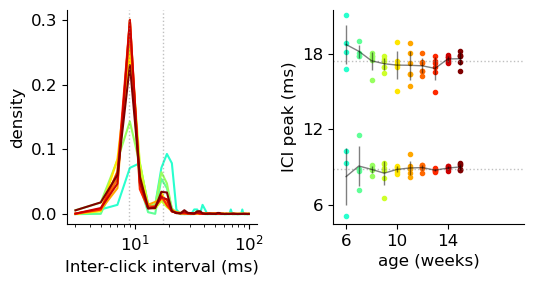

In [88]:
cols = cm.jet
fig,ax = plt.subplots(1,2,figsize=[5.5,3])
for i,a in enumerate(clicks_rm['roundedAge'].unique()[2:]):
    frames = clicks_rm['frame'].loc[(clicks_rm['roundedAge']==a)]
    frames.reset_index(drop=True,inplace=True)
    ICI = np.diff(frames) / sr_rm *1000 
    N,bins = np.histogram(ICI,bins=np.linspace(2,100, 50),density=True)
    xvals = bins[0:-1] +1
    ax[0].plot(xvals,N,alpha=1,linewidth=1.5,color=cols(a/15))
    
ax[0].set_xscale("log")
ax[0].set_xlabel('Inter-click interval (ms)')
ax[0].set_ylabel('density')
removeAxisBox(ax[0])

allpeaks = []
allpeakf = []
agelist = clicks_rm['roundedAge'].unique()[2:] # exclude 4 and 5 wpf because there are no clicks yet

for i,a in enumerate(agelist):
    slowpeak = []
    fastpeak = []
    for n in clicks_rm['channel'].unique():
        frames = clicks_rm['frame'].loc[(clicks_rm['roundedAge']==a) & (clicks_rm['channel']==n)]
        frames.reset_index(drop=True,inplace=True)
        # only consider replicates with at least 20 clicks
        if len(frames) < 20: 
            slowpeak += [np.nan]
            fastpeak += [np.nan]
        else:     
            ICI = np.diff(frames) / sr_rm *1000 
            ICI[ICI < 0] = np.nan
            slowpeak += [np.nanmedian(ICI[(ICI >= 12) & (ICI < 25)])]
            fastpeak += [np.nanmedian(ICI[ICI <= 12])]
    ax[1].plot(np.ones(len(slowpeak))*a, slowpeak, '.', color = cols(a/15))
    ax[1].plot(np.ones(len(slowpeak))*a, fastpeak, '.', color = cols(a/15))
    allpeaks += [slowpeak]
    allpeakf += [fastpeak]

# plot means
ax[1].errorbar(agelist, np.nanmean(allpeaks,axis=1), np.nanstd(allpeaks,axis=1), color= 'k', alpha=.5,lw =1)
ax[1].errorbar(agelist, np.nanmean(allpeakf,axis=1), np.nanstd(allpeakf,axis=1), color= 'k', alpha=.5,lw =1)

# plot reference lines
ax[0].axvline(x=np.nanmean(allpeaks),linestyle=":",color='gray',alpha=.5,linewidth=1)
ax[0].axvline(x=np.nanmean(allpeakf),linestyle=":",color='gray',alpha=.5,linewidth=1)
ax[1].axhline(y=np.nanmean(allpeaks),linestyle=":",color='gray',alpha=.5,linewidth=1)
ax[1].axhline(y=np.nanmean(allpeakf),linestyle=":",color='gray',alpha=.5,linewidth=1)

# axis settings
ax[1].set_ylabel('ICI peak (ms)')
ax[1].set_xlabel('age (weeks)')
ax[1].set_xlim([5,20])
ax[1].set_ylim([4.5,21.5])
ax[1].set_yticks([6,12,18])
ax[1].set_xticks([6,10,14])
removeAxisBox(ax[1])

fig.tight_layout()
print('slow peaks: mean', str(np.nanmean(allpeaks)), '±', np.nanstd(allpeaks), 'STD')
print('fast peaks: mean', str(np.nanmean(allpeakf)), '±', np.nanstd(allpeakf), 'STD')

### Figure 1 H, I and J - Burst plots

In [89]:
# create burst dataframe
allbursts = []
for i,ch in enumerate(clicks_rm['channel'].unique()):
    for a in clicks_rm['age'].unique():
        frames = clicks_rm['frame'].loc[(clicks_rm['age']==a) & (clicks_rm['channel']==ch)]
        frames.reset_index(drop=True,inplace=True)
        
        if len(frames) > 2:
            bursts = group_event(frames,25e-3*sr_rm)
            typelist = [ [] for _ in range(bursts.shape[0]) ] 
            
            for b in range(bursts.shape[0]):
                inds_this_burst = [bursts['startindex'][b],bursts['stopindex'][b]+1]
                frames_inB = frames[inds_this_burst[0]:inds_this_burst[1]].values
                ICIs = np.diff(frames_inB)/sr_rm *1000 
                ICIs[ICIs < 12] = 1 # slow: 60hz
                ICIs[ICIs >= 12] = 0 # fast: 120hz
                
                if len(np.unique(ICIs)) == 1:
                    typelist[b] = int(ICIs[0]) # pure burst, 0: slow and 1: fast
                elif len(np.unique(ICIs)) == 2: 
                    if np.count_nonzero(np.diff(ICIs)) > 1:
                        typelist[b] = 4 # mixed burst with multiple transitions 
                    elif np.sum(np.diff(ICIs)) == 1:
                        typelist[b] = 2 # one transittion, slow to fast
                    elif np.sum(np.diff(ICIs)) == -1:
                        typelist[b] = 3 # one transittion, fast to slow
    
            bursts['type'] = typelist
            bursts['age'] = a
            bursts['channel'] = ch
            allbursts.append(bursts)
            
allbursts = pd.concat(allbursts).reset_index(drop=True)

/var/folders/d2/lzpj3c3s6qd4w9n23sdlm0s80000gn/T/ipykernel_90764/475328367.py:66: RuntimeWarning: Mean of empty slice
  meanbp = np.nanmean(bproballs,axis=0)
/Users/antoniagroneberg/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/d2/lzpj3c3s6qd4w9n23sdlm0s80000gn/T/ipykernel_90764/475328367.py:72: RuntimeWarning: Mean of empty slice
  meanbp = np.nanmean(bproballf,axis=0)
/var/folders/d2/lzpj3c3s6qd4w9n23sdlm0s80000gn/T/ipykernel_90764/475328367.py:78: RuntimeWarning: Mean of empty slice
  ax[1].plot(agelist,np.nanmean(bproballboth,axis=0),':',color='k',lw=1)
/var/folders/d2/lzpj3c3s6qd4w9n23sdlm0s80000gn/T/ipykernel_90764/475328367.py:81: RuntimeWarning: Mean of empty slice
  meanmx = np.nanmean(maxs,axis=0)
/var/folders/d2/lzpj3c3s6qd4w9n23sdlm0s80000gn/T/ipykernel_90764/475328367.py:87: RuntimeWarning: Mean of empty slice
  meanmx = np.

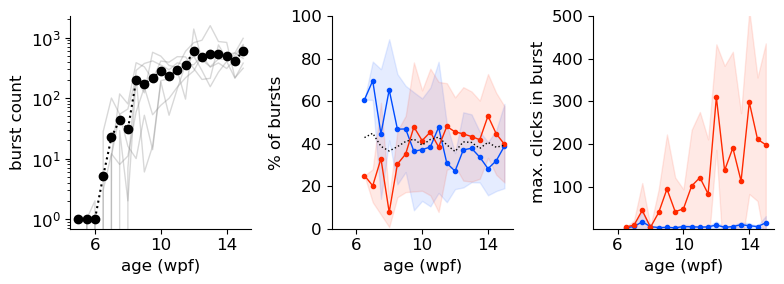

In [93]:
fig,ax = plt.subplots(1,3,figsize=[8,3],sharex=True)
agelist = allbursts['age'].unique()
agelist.sort()

colf = cols(13/15)
colsl = cols(3/15)

bcountall = []
bproballs = []
bproballf = []
bproballboth = []
maxs = []
maxf = []

for chn in allbursts['channel'].unique():
    
    burstcount = []
    bprobs = []
    bprobf = []
    bprobb = []
    maxclciks = []
    maxclcikf = []

    for a in agelist: 
        bthis = allbursts.loc[(allbursts['channel'] == chn) & (allbursts['age'] == a)]
        burstcount += [bthis.shape[0]]
        if bthis.count()[0] > 3:
            # pure slow
            purebs = bthis.loc[(bthis['type'] == 0)]
            bprobs += [(purebs.shape[0])/ bthis.shape[0] *100]
            if purebs.shape[0] > 0:
                maxclciks += [np.max(purebs['numevents'])]
            else: 
                maxclciks += [np.nan]
            # pure fast
            purebf = bthis.loc[(bthis['type'] == 1)]
            bprobf += [(purebf.shape[0])/ bthis.shape[0] *100]
            if purebf.shape[0] > 0:
                maxclcikf += [np.max(purebf['numevents'])]
            else: 
                maxclcikf += [np.nan]
            bprobb += [(purebs.shape[0] + purebf.shape[0]) / bthis.shape[0] *100 /2]    
        else:
            bprobs += [np.nan]
            bprobf += [np.nan]
            maxclciks += [np.nan]
            maxclcikf += [np.nan]
            bprobb += [np.nan]
    #plotlines for burst count
    ax[0].plot(agelist,burstcount,alpha=.3,linewidth=1,color='gray')
    
    bcountall += [burstcount]
    bproballs += [bprobs]
    bproballf += [bprobf]
    bproballboth += [bprobb]
    maxs += [maxclciks]
    maxf += [maxclcikf]

meancount = np.mean(bcountall,axis=0)
meancount[meancount < 1] = 1 # replace 0s bei ones for plotting on log scale
# plot burst count
ax[0].plot(agelist,meancount,':',color='k')
ax[0].plot(agelist,meancount,'ko') 

# plot burst proportion
meanbp = np.nanmean(bproballs,axis=0)
stdbp = np.nanstd(bproballs,axis=0)
ax[1].plot(agelist,meanbp,'-',color=colsl,lw=1)
ax[1].plot(agelist,meanbp,'o',color=colsl,markersize=3)
ax[1].fill_between(agelist,meanbp - stdbp, meanbp + stdbp, color = colsl, alpha = .1)

meanbp = np.nanmean(bproballf,axis=0)
stdbp = np.nanstd(bproballf,axis=0)
ax[1].plot(agelist,meanbp,'-',color=colf,lw=1)
ax[1].plot(agelist,meanbp,'o',color=colf,markersize=3)
ax[1].fill_between(agelist,meanbp - stdbp, meanbp + stdbp, color = colf, alpha = .1)

ax[1].plot(agelist,np.nanmean(bproballboth,axis=0),':',color='k',lw=1)

# plot max. burst length
meanmx = np.nanmean(maxs,axis=0)
stdmx = np.nanstd(maxs,axis=0)
ax[2].plot(agelist,meanmx,'-',color=colsl,lw=1)
ax[2].plot(agelist,meanmx,'o',color=colsl,markersize=3)
ax[2].fill_between(agelist,meanmx - stdmx, meanmx + stdmx, color = colsl, alpha = .1)

meanmx = np.nanmean(maxf,axis=0)
stdmx = np.nanstd(maxf,axis=0)
ax[2].plot(agelist,meanmx,'-',color=colf,lw=1)
ax[2].plot(agelist,meanmx,'o',color=colf,markersize=3)
ax[2].fill_between(agelist,meanmx - stdmx, meanmx + stdmx, color = colf, alpha = .1)

# logs
ax[0].set_yscale('log')
# ax[2].set_yscale('log')
ax[1].set_ylim([0,100])
ax[2].set_ylim([1,500])
#  labels
ax[0].set_ylabel('burst count')
ax[1].set_ylabel('% of bursts')
ax[2].set_ylabel('max. clicks in burst')

for axx in ax:
    axx.set_xticks(np.arange(6,15,4))
    axx.set_xlabel('age (wpf)')
    removeAxisBox(axx)
fig.tight_layout() 

### Figure 2 A - click amplitude 

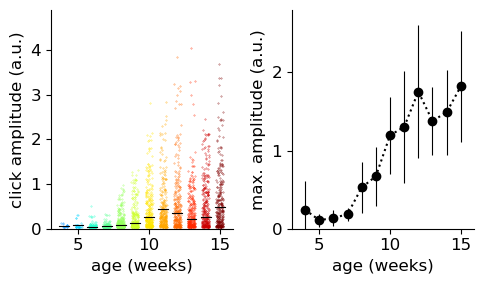

In [95]:
fig,ax = plt.subplots(1,2,figsize=[5,3],sharex=True)
nn = 200 
maxAmpsAll  = []
agelist = clicks_rm['roundedAge'].unique()
for i,a in enumerate(agelist):
    medAmps = []
    maxAmps = []
    for n in clicks_rm['channel'].unique():
        amps = clicks_rm['amplitude'].loc[(clicks_rm['roundedAge']==a) & (clicks_rm['channel']==n)] / 1e7
        amps.reset_index(drop=True,inplace=True)
        if len(amps) < 200:
            nn = len(amps)
            indsr = np.arange(0,nn)
        # chose nn random clicks to plot, if available 
        indsr = np.random.randint(0,len(amps),nn)
        ax[0].plot((np.random.rand(len(indsr))/2) +a-0.25,amps[indsr],'o',color=cols(a/15),markersize=.3,alpha=0.8)
        # get meadian and max values
        if len(amps) > 0:
            medAmps.append(np.nanmedian(amps)) # compile median amp value
            maxAmps.append(np.percentile(amps,95)) # compile 95th percentile amp value
        
    maxAmpsAll.append(np.nanmean(maxAmps))
    ax[0].plot([a-.35,a+.35],[np.nanmedian(medAmps),np.nanmedian(medAmps)],'k-',lw=.8) # plot median across samples
    # plot max values 
    ax[1].plot(a,np.nanmean(maxAmps),'ko')  
    ax[1].errorbar(a,np.nanmean(maxAmps),np.nanstd(maxAmps),color='k',linewidth=.8)  
    
ax[1].plot(agelist,maxAmpsAll,'k:')      
ax[0].set_ylim([0,4.9])  
ax[1].set_ylim([0,2.8])
ax[1].set_yticks([0,1,2])
ax[0].set_ylabel('click amplitude (a.u.)') 
ax[1].set_ylabel('max. amplitude (a.u.)') 

for x in ax:
    x.set_xlabel('age (weeks)') 
    removeAxisBox(x)

fig.tight_layout()

### Figure 2 B - swim bladder sizes

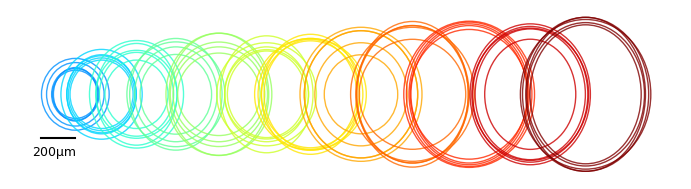

In [96]:
fig, ax = plt.subplots(1,1,figsize=(10,2.2))

offset = 0
for a in morph_rm['Age'].unique():
    thisage = morph_rm.loc[(morph_rm['Age'] == a)]
    thisage.reset_index(inplace=True, drop=True)
    for rep in range(len(thisage)):
        el = Ellipse((offset,0),thisage.iloc[rep]['aSB_Width'],thisage.iloc[rep]['aSB_Height'],edgecolor=cols(a/15),fc='None',lw=1,alpha=0.8)
        ax.add_patch(el)    
    offset += thisage['aSB_Width'].mean()/2
    
ax.set_aspect('equal')
plt.axis('off')
plt.plot(np.array([-200,0]), np.array([-250,-250]),c='black')
ax.text(-250,-350,'200μm',fontsize=9); #μm    

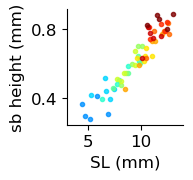

In [97]:
fig,ax = plt.subplots(1,1,figsize=[1.5,1.5])
for a in morph_rm['Age'].unique():
    thisage = morph_rm.loc[(morph_rm['Age'] == a)]
    thisage.reset_index(inplace=True, drop=True)
    for rep in range(len(thisage)):
        ax.plot(thisage.iloc[rep]['BL']/1000,thisage.iloc[rep]['aSB_Height']/1000,'.',color=cols(a/15),alpha=.8)

removeAxisBox(ax)
ax.set_xlabel('SL (mm)')
ax.set_ylabel('sb height (mm)')
ax.set_xlim([3,14])
ax.set_yticks([.4,.8]);

# Dataset 2: close-range (cr) click recordings

In [6]:
# load the data
clicks_cr = pd.read_hdf(os.path.join(path, 'CR_100CenterClicks.h5'),'CenterClicks')
keys = clicks_cr['Group'].unique()
sr_cr = 102400 
morph_cr = pd.read_csv(os.path.join(path, 'CR_Morph.csv'))

### explanation of data structures

In [7]:
print('clicks_rm variable:')
clicks_cr.head()

clicks_rm variable:


,Group,Click_ID,Amplitude,maxChn,Data
0,adult,20230808_1004_334097257,0.081800,3,"[[0.0010105371, 0.0010057688, 0.0004171133, 0...."
1,adult,20230808_0800_495327665,0.062741,3,"[[0.0009049177, 0.00026857853, -0.00016927719,..."
2,adult,20230808_0800_604705926,0.057351,4,"[[0.0002502203, 0.00029993057, 0.00094246864, ..."
3,adult,20230808_0800_432394549,0.082742,1,"[[0.002195835, 0.0017558336, 0.0015618801, 0.0..."
4,adult,20230808_0800_453606655,0.059372,3,"[[-0.0040677786, -0.0033246279, -0.003823042, ..."


dataframe object for CR click data: 
* 'Group' indicates tested age group
* 'Click_ID' unique click identifier
* 'Amplitude' of the detected click in arbitrary units
* 'maxChn' channel with the maximum click amplitude from multi-hydrophone recording
* 'Data' time series of the hydrophone channels around the click 

In [152]:
print('morph_cr variable:')
morph_cr.head()

morph_cr variable:


,Group,BL,aSB_Height,aSB_Width
0,w6,10.372816,0.819203,0.679669
1,w6,9.502690,0.733682,0.666165
2,w6,9.319506,0.697673,0.661664
3,w5,9.708773,0.715677,0.643660
4,w5,8.861545,0.634657,0.549136


dataframe object for morphology data:

* 'Group' indicates tested age group
* 'BL' body length measure as standard length (nose to tail base) in μm
* 'aSB_Height' dorso-ventral measure of the diameter of the anterior swim bladder in μm
* 'aSB_Width' rosto-caudal measure of the diameter of the anterior swim bladder in μm

In [8]:
def V2Pa(audio):
    vrange=5 # maximum voltage
    
    ct2v=float(vrange)/(2**31)
    gain=10**(50/20) #(50db) PA-4
    v2p = 1/40e-6 # -208dBV re 1μPa (40μV / Pascal) (AS-1)
    
    return v2p*ct2v/gain * audio * 1e9

#convert from Pascals to dB re 1uPa (SPL)
def Pa2dB(audio_Pa, p0 = 1e-6):
    audio_Pa = np.array(audio_Pa)
    Lp = 20 * np.log10(audio_Pa/p0)
    return Lp

### Figure 2 C - click profiles

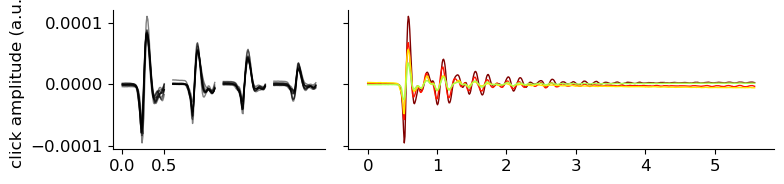

In [9]:
# plot cropped clicks - n loudest clicks and single loudest as overlay
num = 10
col = cm.jet
fig,ax = plt.subplots(1,2,figsize=(8,2), gridspec_kw={'width_ratios': [1, 2]}, sharey=True)
for i,k in enumerate(keys):
    dd = clicks_cr.loc[(clicks_cr['Group']==k)].reset_index(drop=True)
    dd.sort_values('Amplitude',ascending=False,inplace=True)
    dd = dd.reset_index(drop=True)
    
    age = k.split('_')[0]
    if age == 'adult':
        a = 9
    else:
        a = int(age.split('w')[-1])
    
    for n in range(num):
        chn = dd['maxChn'][n]
        trace = dd['Data'][n][:,chn]
        maxi = np.argmax(trace)
        ctrace = trace[int(maxi-30):int(maxi+(sr_cr*0.00022))] 
        # plot the traces 
        ax[0].plot((np.arange(0,len(ctrace)) /sr_cr*1000) +(i*.6),ctrace/1e3, color='k', lw=1, alpha=.5)
        if n == 0:
            ctrace = trace[int(maxi-60):int(maxi+(sr_cr*0.005))]
            ax[1].plot(np.arange(0,len(ctrace))/sr_cr*1000,ctrace /1e3,color=col(a/9),linewidth=1,alpha=1)
    
removeAxisBox(ax[0])  
removeAxisBox(ax[1]) 
ax[0].set_xticks([0,0.5])
ax[0].set_ylabel('click amplitude (a.u.)')
fig.tight_layout()

### Fig. 2 D and E - SPL and peak-to-peak time vs. swim bladder size 

PearsonRResult(statistic=0.9869800781885398, pvalue=0.013019921811460167)
PearsonRResult(statistic=0.19896361615776392, pvalue=0.8010363838422361)


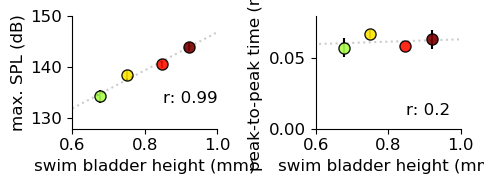

In [10]:
# 2. plot amp vs. sb and peak to peak vs. sb
num = 10
col = cm.jet
fig,ax = plt.subplots(1,2,figsize=(5,2),sharex=True)

xcomp = []
ycomp_a = []
ycomp_b = []

for i,k in enumerate(keys[-1::-1]):
    dd = clicks_cr.loc[(clicks_cr['Group']==k)].reset_index(drop=True)
    dd.sort_values('Amplitude',ascending=False,inplace=True)
    dd = dd.reset_index(drop=True)
    
    Sb = morph_cr.loc[(morph_cr['Group']) == k]['aSB_Height'].mean() /1000
    
    age = k.split('_')[0]
    if age == 'adult':
        a = 9
    else:
        a = int(age.split('w')[-1])
    
    peak2peak = []  
    maxamp = []
    for n in range(num):
        chn = dd['maxChn'][n]
        trace = dd['Data'][n][:,chn]
        maxi = np.argmax(trace)
        mini = np.argmin(trace)
        # convert max amplitude to dB
        audio_Pa = V2Pa(np.max(dd['Data'][n]))
        SPL = Pa2dB(audio_Pa)
        maxamp.append(SPL)
        # get peak to peak time
        peak2peak.append((maxi - mini) / sr_cr *1000)
        
    # plot max amp 
    ax[0].errorbar(Sb,np.mean(maxamp),np.std(maxamp),color='k')
    ax[0].plot(Sb,np.mean(maxamp),'o',color=col(a/9),markersize=8,alpha=0.9,markeredgecolor='k')

    ax[1].errorbar(Sb,np.mean(peak2peak),np.std(peak2peak),color='k')
    ax[1].plot(Sb,np.mean(peak2peak),'o',color=col(a/9),markersize=8,alpha=0.9,markeredgecolor='k')
    
    # compile for correlation 
    xcomp.append(Sb)
    ycomp_a.append(np.mean(maxamp))
    ycomp_b.append(np.mean(peak2peak))

for x in ax:
    removeAxisBox(x)
    x.set_xlim([0.6,1])
    x.set_xlabel('swim bladder height (mm)')

ax[0].set_ylim([128,150])
ax[0].set_ylabel('max. SPL (dB)')
ax[1].set_ylim([0,.08])
ax[1].set_ylabel('peak-to-peak time (ms)')

# add correlation
xcomp = np.stack(xcomp).reshape((1,len(keys)))
ycomp_a = np.stack(ycomp_a).reshape((1,len(keys)))
ycomp_b = np.stack(ycomp_b).reshape((1,len(keys)))

res = scipy.stats.linregress(xcomp[0],ycomp_a[0])
ax[0].plot([0,1],[res.intercept, res.intercept+res.slope], 'k:',alpha=.2)
ax[0].text(.85,133,'r: ' + str(round(res.rvalue,2)))

res2 = scipy.stats.linregress(xcomp[0],ycomp_b[0])
ax[1].plot([0,1],[res2.intercept, res2.intercept+res2.slope], 'k:',alpha=.2)
ax[1].text(.85,.01,'r: ' + str(round(res2.rvalue,2)))

fig.tight_layout()

print(scipy.stats.pearsonr(xcomp[0],ycomp_a[0]))
print(scipy.stats.pearsonr(xcomp[0],ycomp_b[0]))

### Figure S1 B and C - frequency spectrum of clicks 

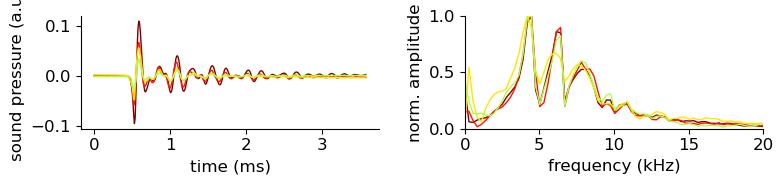

In [28]:
fig,ax = plt.subplots(1,2,figsize=(8,2))
col = cm.jet

for i,k in enumerate(keys):
    dd = clicks_cr.loc[(clicks_cr['Group']==k)].reset_index(drop=True)
    dd.sort_values('Amplitude',ascending=False,inplace=True)
    dd = dd.reset_index(drop=True)
    
    age = k.split('_')[0]
    if age == 'adult':
        a = 9
    else:
        a = int(age.split('w')[-1])
    
    chn = dd['maxChn'][0]
    trace = dd['Data'][0][:,chn]
    maxi = np.argmax(trace)
    ctrace = trace[int(maxi-(60)):int(maxi+(sr_cr*0.003))]
    ax[0].plot(np.arange(0,len(ctrace))/sr_cr*1000,ctrace,color=col(a/9),linewidth=1,alpha=1)
    fourier = np.fft.rfft(ctrace)
    n = ctrace.size
    freq = np.fft.rfftfreq(n, d=1./sr_cr)
    amp = np.abs(fourier) 
    amp = amp / amp.max()
    ax[1].plot(freq/1e3,amp,color=col(a/9),linewidth=1,alpha=1)

ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('sound pressure (a.u.)')

removeAxisBox(ax[0])
removeAxisBox(ax[1])
ax[1].set_xlim([0,20])
ax[1].set_ylim([0,1])
ax[1].set_xlabel('frequency (kHz)');
ax[1].set_ylabel('norm. amplitude')

fig.tight_layout()

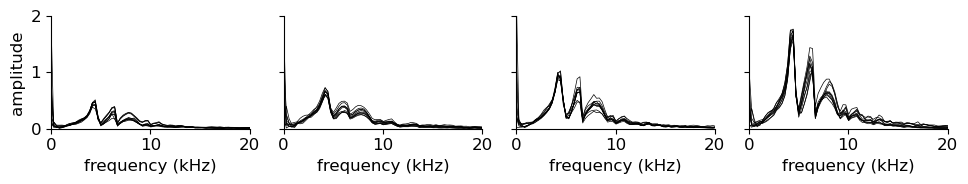

In [26]:
fig,ax = plt.subplots(1,4,figsize=(10,2),sharey=True)
num = 10

for i,k in enumerate(keys[-1::-1]):
    dd = clicks_cr.loc[(clicks_cr['Group']==k)].reset_index(drop=True)
    dd.sort_values('Amplitude',ascending=False,inplace=True)
    dd = dd.reset_index(drop=True)

    age = k.split('_')[0]
    if age == 'adult':
        a = 9
    else:
        a = int(age.split('w')[-1])
    
    for n in range(num):
        chn = dd['maxChn'][n]
        trace = dd['Data'][n][:,chn]
        maxi = np.argmax(trace)
        ctrace = trace[int(maxi-60):int(maxi+(sr_cr*0.003))]
        fourier = np.fft.rfft(ctrace)
        n = ctrace.size
        freq = np.fft.rfftfreq(n, d=1./sr_cr)
        ax[i].plot(freq/1e3,np.abs(fourier),color='k',linewidth=.5,alpha=1)

    removeAxisBox(ax[i])
    ax[i].set_xlim([0,20])
    ax[i].set_ylim([0,2])
    ax[i].set_xlabel('frequency (kHz)');
ax[0].set_ylabel('amplitude')

fig.tight_layout()

### Figure S2 A - example spectograms of bursts

In [165]:
# load traces
with open(path + '/CR_example_traces.npy', 'rb') as f: 
    traces = np.load(f)

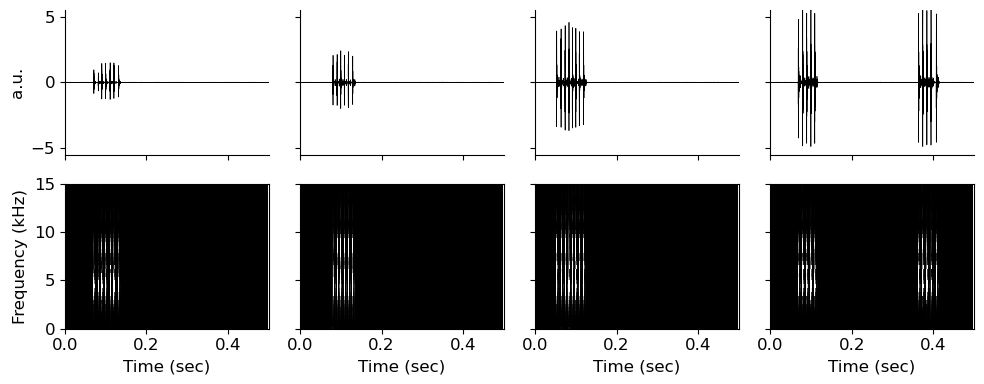

In [169]:
fig,ax = plt.subplots(2,4,figsize=(10,4),sharex=True)
nfft = 256
noverlap = int(nfft*0.99) 
nperseg = 256
max_freq = 15000 /1e3

for c in range(0,traces.shape[1]):
    tr = traces[:,c]
    f, t, Sxx = signal.spectrogram(np.array(tr), nfft=nfft, fs=sr_cr, nperseg = nperseg, noverlap=noverlap)
    xvals = np.arange(0,len(tr)) /sr_cr
    ax[0,c].plot(xvals,tr*100,lw=.5,c='k')
    removeAxisBox(ax[0,c])
    ax[0,c].set_ylim(-5.5, 5.5)
    ax[0,c].set_xlim(0, xvals[-1])

    ax[1,c].pcolormesh(t, f/1e3, Sxx, vmin=0,vmax=np.max(Sxx)/20,cmap='gray')  
    ax[1,c].set_ylim(0, max_freq)
    
    if c > 0:
        ax[0,c].set_yticks([-5,0,5],[])  
        ax[1,c].set_yticks([0,5,10,15],[])  
    
    ax[1,c].set_xlabel('Time (sec)')
ax[1,0].set_ylabel('Frequency (kHz)')
ax[0,0].set_ylabel('a.u.')

fig.tight_layout()

# Dataset 3 - 24h recordings in juvenile fish 

In [192]:
# load data
clicks_24h = pd.read_hdf(os.path.join(path,'24hrec_CompiledClicks.h5'))
morph_24h = pd.read_csv(os.path.join(path,'24hrec_Morph.csv'))
sr_24 = 51200

In [184]:
print('clicks_24h variable:')
clicks_24h.head()

clicks_24h variable:


,frame,channel,amplitude,rec_day
0,1.689115e+09,0.0,1.704428e+06,1.0
1,1.689465e+09,0.0,3.853633e+05,1.0
2,1.771130e+09,0.0,1.882664e+06,1.0
3,1.818838e+09,0.0,6.010718e+05,1.0
4,1.835888e+09,0.0,1.818713e+06,1.0


dataframe object for click data:

* 'frame' indicates the acquisition frame at which a click was detected, needs to be divided by the sample rate sr_rm to obtain time in seconds
* 'channel' reports the hydrophone channel the click was detected on: channel 0-2: less devleped juveniles, 3-5: more mature. Corresponds to Group name in morph_24h variable; i.e. 'week5_ai0' is channel=0.0 in the click_24h, 'week5_ai1': channel=1.0 etc. 
* 'amplitude' of the detected click in arbitrary units
* 'rec_day' refers to the recording day at which the data was acquired

### Figure S1 - circadian click distribution  

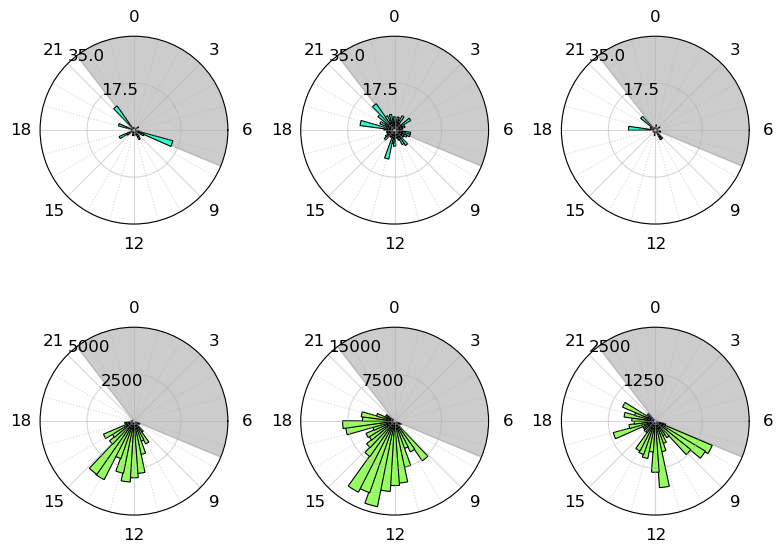

In [188]:
# plot circular histograms 
binsize = 30 # in min 
bins = np.arange(0,60*60*24,60*binsize) 
zeropoint = 6
p = 231
rmax = 15e3

c = cm.jet
age = [6,6,6,8,8,8] # for color coding
fig = plt.figure(figsize=(8,6))

for n in clicks_24h['channel'].unique():

    frames = clicks_24h.loc[(clicks_24h['channel'] == n)]['frame']
    N, b = np.histogram(frames/sr_24, bins)

    t = np.linspace(0,24,bins.size -1) - zeropoint
    theta = t/24 * 2 * np.pi
    ax = plt.subplot(p,projection='polar')
    # shading for day time
    rbin = 2*np.pi / 24 # 30min windows
    end = 1.5 * rbin # start time 7:30am
    start = 8.5 * rbin
    ax.axvspan(-start,end,0,rmax/2, color='gray', alpha=0.4)
    # add data
    ax.bar(theta, N, width=.15, color=c(age[int(n)]/15), edgecolor='k', alpha=1, lw=.8)
    ax.set_rmin(0)
    ax.set_theta_direction(-1)
    
    # adjust axis lims
    rmax = 15e3
    if np.max(N) < 5500:
        rmax = 5e3
    if np.max(N) < 2000:
        rmax = 2.5e3
    if np.max(N) < 20:
        rmax = 35
    ax.set_rmax(rmax)

    ax.tick_params(which='minor',grid_alpha=.5,grid_linestyle=':')
    ax.tick_params(which='major',grid_alpha=.5)
    ax.set_xticks(np.pi/180. * np.linspace(0,  360, 24, endpoint=False),minor=True)
    ax.set_xticks(np.pi/180. * np.linspace(0,  360, 8, endpoint=False))  # 8 labels
    ax.set_xticklabels(['6', '9', '12', '15', '18', '21', '0', '3'])
    ax.set_rgrids([rmax/2, rmax])
    ax.grid(True, which='minor')
    ax.set_rlabel_position(225)

    p += 1
    
fig.tight_layout()
plt.show()

In [191]:
# print the mean and SD values of standard length per group
for m in morph_24h['Group'].unique(): 
    BL = morph_24h.loc[(morph_24h['Group']) == m]['BL'].mean() /1000
    SD = morph_24h.loc[(morph_24h['Group']) == m]['BL'].std() /1000
    print(m, BL, ' ± ', SD)

week5_ai0 8.727806333333334  ±  0.15623756965702365
week5_ai1 8.786799333333333  ±  0.1800829941730565
week5_ai2 8.643412666666665  ±  0.15754618910761853
week5_ai3 9.361410333333334  ±  0.2778167493408805
week5_ai4 9.262694000000002  ±  0.20783574879457115
week5_ai5 9.132359666666668  ±  0.2977539599675091
